In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import statistics
import time

In [2]:
ray.init(ignore_reinit_error=True)
print(f"Dashboard URL: http://{ray.get_dashboard_url()}")

File descriptor limit 256 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'
2021-03-27 23:03:16,873	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


Dashboard URL: http://127.0.0.1:8265


In [3]:
def estimate_pi (num_samples):
    xs = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the x coordinate
    ys = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the y coordinate
    xys = np.stack((xs, ys), axis=-1)                              # similar to Python's "zip(a,b)"; creates np.array([(x1,y1), (x2,y2), ...]).

    inside = (xs**2.0 + ys**2.0) <= 1.0                            # create a predicate over all the array elements
    xys_inside = xys[inside]                                       # select only those  elements inside the circle
    in_circle = xys_inside.shape[0]                                # return the number of elements inside the circle
    approx_pi = 4.0 * in_circle / num_samples                      # the Pi estimate

    return approx_pi

In [4]:
@ray.remote
def ray_estimate_pi (num_samples):
    return estimate_pi(num_samples)

In [5]:
def measure_epoch (n, trials=20, distrib=False):
    start = time.time()
    
    if distrib:
        refs = [ray_estimate_pi.remote(n) for _ in range(trials)]
        pis = ray.get(refs)
    else:
        pis = [estimate_pi(n) for _ in range(trials)]

    duration = time.time() - start
    approx_pi = statistics.mean(pis)
    stdev = statistics.stdev(pis)
    error = 100.0 * abs(approx_pi - np.pi) / np.pi

    return n, duration, approx_pi, stdev, error

In [6]:
def run_sim (distrib=False, max_n=100000, step=50000):
    results = [
        measure_epoch(n, distrib=distrib)
        for n in range(10, max_n, step)
    ]
    
    columns = ["n", "duration", "approx_pi", "stdev", "error"]
    df = pd.DataFrame(results, columns=columns)

    plt.plot("n", "error", data=df, marker="", color="red", linewidth=0.5, linestyle="dashed")
    plt.plot("n", "stdev", data=df, marker="", color="blue", linewidth=2)
    plt.plot("n", "duration", data=df, marker="", color="green", linewidth=1, linestyle="dashed")

    plt.yscale("log")
    plt.legend()
    plt.show()
    
    return df

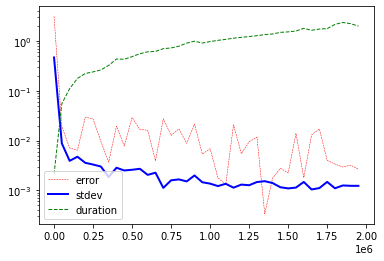

,n,duration,approx_pi,stdev,error
0,10,0.002118,3.240000,0.466115,3.132403
1,50010,0.055114,3.140992,0.008771,0.019126
2,100010,0.110380,3.141816,0.003922,0.007104
3,150010,0.176881,3.141392,0.004742,0.006390
4,200010,0.222108,3.142516,0.003577,0.029387
5,250010,0.238950,3.142448,0.003307,0.027223
6,300010,0.261982,3.141897,0.003016,0.009675
7,350010,0.322487,3.141477,0.001853,0.003696
8,400010,0.433984,3.142205,0.002848,0.019506
9,450010,0.429848,3.141349,0.002513,0.007746


In [7]:
df1 = run_sim(distrib=False, max_n=2000000)
df1

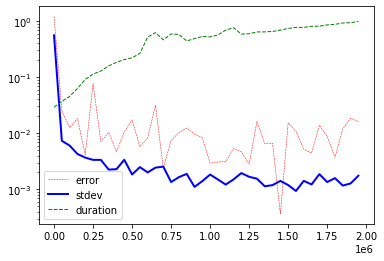

,n,duration,approx_pi,stdev,error
0,10,0.029168,3.180000,0.557815,1.222544
1,50010,0.037081,3.140796,0.007337,0.025363
2,100010,0.045535,3.141988,0.006026,0.012578
3,150010,0.062866,3.142169,0.004267,0.018352
4,200010,0.091232,3.141462,0.003671,0.004161
5,250010,0.113434,3.139178,0.003347,0.076872
6,300010,0.129074,3.141371,0.003348,0.007068
7,350010,0.158935,3.141267,0.002247,0.010372
8,400010,0.183981,3.141739,0.002284,0.004657
9,450010,0.206545,3.141923,0.003360,0.010503


In [8]:
df2 = run_sim(distrib=True, max_n=2000000)
df2

In [9]:
degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

X = df1.iloc[:, 0].values.reshape(-1, 1)
Y1 = df1.iloc[:, 1].values.reshape(-1, 1)
Y2 = df2.iloc[:, 1].values.reshape(-1, 1)

polyreg.fit(X, Y1)
Y1_pred = polyreg.predict(X)

polyreg.fit(X, Y2)
Y2_pred = polyreg.predict(X)

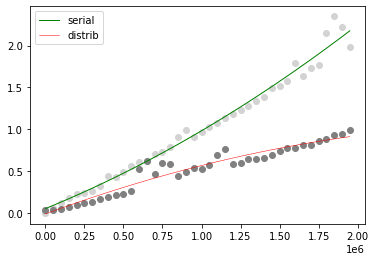

In [10]:
plt.scatter(X, Y1, color="lightgray")
plt.scatter(X, Y2, color="gray")

plt.plot(X, Y1_pred, color="green", linewidth=1, label="serial")
plt.plot(X, Y2_pred, color="red", linewidth=0.5, label="distrib")

plt.legend()
plt.show()